In [1]:
# this code analyses and predicts the chiller performance ['ch1_kW'] based on ['amb_temp','run_sts','vsd_freq','ch1_kW','pp*_FB','sup_temp1','ret_temp1']

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from scipy import interpolate
import matplotlib.pyplot as plt
import pymssql
# import pyodbc  as pdc
import sqlalchemy as sa

import plotly.express as px
import urllib.parse

import re
import tqdm
import os


import warnings
warnings.filterwarnings('ignore')


server='40.123.229.239'
username='smartae'
password = os.getenv('SQL_PASSWORD')
database='master'
encoded_password = urllib.parse.quote_plus(password)

conn = pymssql.connect(server, username, password, "master")
cursor = conn.cursor(as_dict=True)

import pickle
def Export(modelname,filename):
    path=f'models/{filename}.pkl'
    # print(f'{modelname} was saved at {path}')
    with open(path,'wb') as f:
        pickle.dump(modelname,f)


In [3]:
df=pd.read_csv('../SQLMasterMetaData2.csv').drop(['Unnamed: 0'],axis=1)
df[df['TABLE_NAME'].str.contains('R320')].TABLE_NAME.values

parameters={'run_sts': 'R320_1_CH1_RUN_STS', 'vsd_freq': 'R320_2_CH1_VSD_OUTFREQ',
          'ch1_kW': 'R320_2_CH1_METER_TOTAL_ACTIVE_POWER',
          'pp1': 'R320_1_PP1_FB', 'pp2': 'R320_1_PP2_FB', 'pp3': 'R320_1_PP3_FB', 'pp4': 'R320_1_PP4_FB',
          'pp5': 'R320_1_PP5_FB', 'pp6': 'R320_1_PP6_FB', 'pp7': 'R320_1_PP7_FB', 'pp8': 'R320_1_PP8_FB',
          'sup_temp1': 'R320_2_CH1_SUP_WTRTEMP', 'ret_temp1': 'R320_2_CH1_RET_WTRTEMP',
          'sup_temp4': 'R320_2_CH4_SUP_WTRTEMP', 'ret_temp4': 'R320_2_CH4_RET_WTRTEMP', 
          'sup_temp2': 'R320_1_CH2_sup_temp', 'ret_temp2': 'R320_1_CH2_RET_TEMP', 
          'sup_temp3': 'R320_1_CH3_sup_temp', 'ret_temp3': 'R320_1_CH3_RET_TEMP', 
          'ch4_kW': 'R320_2_CH4_METER_TOTAL_ACTIVE_POWER',
          'ch2_kW1': 'R320_2_CH2A_METER_Total_Active_power', 'ch2_kW2': 'R320_2_CH2B_METER_Total_Active_power',
          'ch3_kW1': 'R320_2_CH3A_METER_Total_Active_power', 'ch3_kW2': 'R320_2_CH3B_METER_Total_Active_power',
          }

ch_parms=list(parameters.values())
labels=list(parameters.keys())
# print(df[df['TABLE_NAME'].str.contains('R320')].TABLE_NAME.values)



In [4]:
ignored=[]
res=pd.DataFrame()
for i,point in enumerate(ch_parms[:]):
        
        # point=rtus[3]
        query1=f"""SELECT 
                Timestamp,[VALUE] as {labels[i]}
                FROM [niagara].[dbo].{point}
                where timestamp < '2023-09-01'"""
        # print(query1)
        # cursor.execute(query1)
        # tempdf=pd.DataFrame(cursor.fetchall())
        tempdf=pd.read_sql(query1,conn)
        if len(tempdf)<10000:
            print(point,'==> IGNORED!!!')
            ignored.append(point)
            continue
        tempdf=tempdf.groupby(pd.Grouper(key='Timestamp',freq='15min')).mean().round(2).dropna()
        res=res.join(tempdf,how='outer')
res['run_sts']=res.run_sts.fillna(method='ffill')
res['run_sts']=res.run_sts.fillna(method='bfill')

res


,run_sts,vsd_freq,ch1_kW,pp1,pp2,pp3,pp4,pp5,pp6,pp7,...,ret_temp4,sup_temp2,ret_temp2,sup_temp3,ret_temp3,ch4_kW,ch2_kW1,ch2_kW2,ch3_kW1,ch3_kW2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-17 15:00:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-17 15:15:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-17 15:30:00,1.0,137.3,NaN,100.0,100.00,100.00,100.00,100.00,0.11,0.59,...,NaN,43.27,49.12,15.72,35.35,NaN,NaN,NaN,NaN,NaN
2019-09-17 15:45:00,1.0,137.3,0.14,100.0,100.00,100.00,100.00,100.00,0.10,0.60,...,10.33,43.44,48.63,15.77,35.43,0.12,0.68,0.66,0.68,0.00
2019-09-17 16:00:00,1.0,137.3,0.14,100.0,100.00,100.00,100.00,100.00,0.12,0.61,...,10.33,43.35,47.69,15.82,35.60,0.12,0.68,0.66,0.68,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 22:45:00,1.0,91.7,86.46,0.9,79.69,79.63,79.65,79.79,79.62,79.64,...,11.61,11.82,11.87,21.78,23.68,86.65,0.66,0.65,0.66,0.64
2023-08-31 23:00:00,1.0,99.3,94.22,0.9,77.66,77.61,77.60,77.76,77.59,77.62,...,12.22,11.82,11.87,21.78,23.68,88.90,0.66,0.65,0.67,0.64
2023-08-31 23:15:00,1.0,94.5,85.94,0.9,74.64,74.58,73.55,74.74,74.54,74.59,...,12.06,11.82,11.87,21.78,23.68,88.00,0.67,0.65,0.67,0.64


In [5]:
# which method of approximation is the most accurate
d1=res.copy()

# optimized temp 2 (weather.com data)
temp=pd.read_csv('amb_temp_hr.csv',index_col='Timestamp')
temp.index=pd.to_datetime(temp.index)
d1=d1.groupby(pd.Grouper(freq='1h')).mean().iloc[1:]
d1['amb_temp']=temp
for i,r in d1.iterrows():
    if r.ret_temp4>16:
        d1.loc[i,'ret_temp4']=12
    if r.ret_temp1>16:
        d1.loc[i,'ret_temp1']=12
    if r.sup_temp1<5:
        d1.loc[i,'ret_temp1']=7
    if r.sup_temp4<5:
        d1.loc[i,'ret_temp4']=7

# d1['run_sts_rounded']=d1['run_sts'].round()
# d1['run_sts_p1rounded']=(d1['run_sts']+.1).round()
# d1=d1[~d1['ch1_kW'].isna()]


# for next time use d1.assign() 
# like https://www.kaggle.com/code/tetsutani/ps3e18-eda-ensemble-ml-pipeline-binarypredictict#Feature-Engineering

d1['ch2_kW']=d1.ch2_kW1+d1.ch2_kW2
d1['ch3_kW']=d1.ch3_kW1+d1.ch3_kW2
d1['ch1_run_sts']=d1.ch1_kW.apply(lambda x: 1 if x>10 else 0)
d1['ch2_run_sts']=d1.ch2_kW.apply(lambda x: 1 if x>10 else 0)
d1['ch3_run_sts']=d1.ch3_kW.apply(lambda x: 1 if x>10 else 0)
d1['ch4_run_sts']=d1.ch4_kW.apply(lambda x: 1 if x>10 else 0)
d1['NR_ch']=d1.ch1_run_sts+d1.ch2_run_sts+d1.ch3_run_sts+d1.ch4_run_sts
d1['fper_ch']=d1.apply(lambda x: 0 if x.NR_ch==0 else (x.pp1+x.pp2+x.pp3+x.pp4+x.pp5+x.pp6+x.pp7+x.pp8)/x.NR_ch,axis=1)

# d1=d1[~d1.fper_ch.isna()]
d1['dT1']=d1.apply(lambda x: max(0,x.ret_temp1-x.sup_temp1),axis=1)
d1['dT2']=d1.apply(lambda x: max(0,x.ret_temp2-x.sup_temp2),axis=1)
d1['dT3']=d1.apply(lambda x: max(0,x.ret_temp3-x.sup_temp3),axis=1)
d1['dT4']=d1.apply(lambda x: max(0,x.ret_temp4-x.sup_temp4),axis=1)
runs=[i for i in d1.columns if 'run' in i.lower()]
runs=['run_sts_p1rounded', 'ch1_run_sts']
d1.head()





,run_sts,vsd_freq,ch1_kW,pp1,pp2,pp3,pp4,pp5,pp6,pp7,...,ch1_run_sts,ch2_run_sts,ch3_run_sts,ch4_run_sts,NR_ch,fper_ch,dT1,dT2,dT3,dT4
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-17 16:00:00,1.0,138.775,0.1400,100.0,100.0,100.0,100.0,100.0,0.1100,0.6025,...,0,0,0,0,0,0.0,4.7325,6.0375,19.7250,4.1225
2019-09-17 17:00:00,1.0,130.625,0.1325,100.0,100.0,100.0,100.0,100.0,0.1050,0.5950,...,0,0,0,0,0,0.0,4.3025,6.1875,19.9050,3.8200
2019-09-17 18:00:00,1.0,128.450,0.1300,100.0,100.0,100.0,100.0,100.0,0.1150,0.6075,...,0,0,0,0,0,0.0,4.1800,5.8050,20.1675,3.6950
2019-09-17 19:00:00,1.0,123.825,0.1200,100.0,100.0,100.0,100.0,100.0,0.1175,0.6100,...,0,0,0,0,0,0.0,3.9975,6.0475,20.5350,3.4850
2019-09-17 20:00:00,1.0,115.000,0.1075,100.0,100.0,100.0,100.0,100.0,0.1100,0.6000,...,0,0,0,0,0,0.0,3.6375,6.0475,20.7475,3.1675


In [6]:
def cal(d1):
    s=0
    count=1
    for c in ['pp1','pp2','pp3','pp4','pp5','pp6','pp7','pp8']:
        if d1[c]<20:
            continue
        else:
            s+=d1[c]
            count+=1
        
    return s/count

pp_avg=d1[['pp1','pp2','pp3','pp4','pp5','pp6','pp7','pp8']].apply(lambda x: cal(x),axis=1)

### TR Calculation

In [7]:

dd=d1.copy()
dd.drop(['pp1','pp2','pp3','pp4','pp5','pp6','pp7','pp8'],axis=1,inplace=True)
pmp_flow= 80 # meter cube per hour
dd['tr1']=pmp_flow*1000*dd.dT1*2*pp_avg/302400
dd['tr2']=pmp_flow*1000*dd.dT2*2*pp_avg/302400
dd['tr3']=pmp_flow*1000*dd.dT3*2*pp_avg/302400
dd['tr4']=pmp_flow*1000*dd.dT4*2*pp_avg/302400
dd['tr_total_new']=dd.tr1+dd.tr4
dd['tr_total']=dd.tr1+dd.tr4+dd.tr2+dd.tr3


### Capacity%

In [8]:
dd['max_cap']=280*(dd['NR_ch']).apply(lambda x: max(1,x))
dd['capacity%']=dd.tr_total/dd.max_cap


<AxesSubplot: >

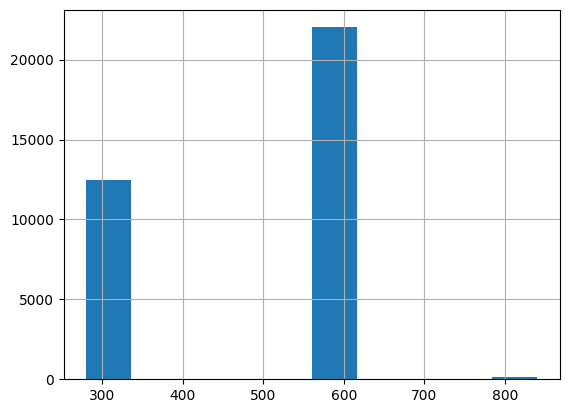

In [9]:
dd.max_cap.hist()

### Old Max kW

In [10]:
old=pd.read_csv('Recip_comp_ch.csv')
f=interpolate.interp1d(old['capacity%'],old['power%'],fill_value='extrapolate')
max_power=max(dd.ch1_kW)
# dd['old_max_kW']=f(dd['cload_%_'])*max_power
dd['old_max_kW']=f(dd['capacity%'])*max_power * 2 # for both chillers
dd['power_%']=dd.apply(lambda x: x.ch1_kW/x.old_max_kW,axis=1)
dd['old_max_kW']
dd['ch14_kWh']=dd.ch1_kW+dd.ch4_kW

dd['old_max_kW']

Timestamp
2019-09-17 16:00:00    1631.365290
2019-09-17 17:00:00    1616.187116
2019-09-17 18:00:00    1602.328782
2019-09-17 19:00:00    1610.530653
2019-09-17 20:00:00    1592.995619
                          ...     
2023-08-31 19:00:00     526.188840
2023-08-31 20:00:00     514.367759
2023-08-31 21:00:00     500.531580
2023-08-31 22:00:00     479.692850
2023-08-31 23:00:00     466.170925
Freq: H, Name: old_max_kW, Length: 34664, dtype: float64

In [11]:
dd.columns

Index(['run_sts', 'vsd_freq', 'ch1_kW', 'sup_temp1', 'ret_temp1', 'sup_temp4',
       'ret_temp4', 'sup_temp2', 'ret_temp2', 'sup_temp3', 'ret_temp3',
       'ch4_kW', 'ch2_kW1', 'ch2_kW2', 'ch3_kW1', 'ch3_kW2', 'amb_temp',
       'ch2_kW', 'ch3_kW', 'ch1_run_sts', 'ch2_run_sts', 'ch3_run_sts',
       'ch4_run_sts', 'NR_ch', 'fper_ch', 'dT1', 'dT2', 'dT3', 'dT4', 'tr1',
       'tr2', 'tr3', 'tr4', 'tr_total_new', 'tr_total', 'max_cap', 'capacity%',
       'old_max_kW', 'power_%', 'ch14_kWh'],
      dtype='object')

In [12]:
dd.columns

Index(['run_sts', 'vsd_freq', 'ch1_kW', 'sup_temp1', 'ret_temp1', 'sup_temp4',
       'ret_temp4', 'sup_temp2', 'ret_temp2', 'sup_temp3', 'ret_temp3',
       'ch4_kW', 'ch2_kW1', 'ch2_kW2', 'ch3_kW1', 'ch3_kW2', 'amb_temp',
       'ch2_kW', 'ch3_kW', 'ch1_run_sts', 'ch2_run_sts', 'ch3_run_sts',
       'ch4_run_sts', 'NR_ch', 'fper_ch', 'dT1', 'dT2', 'dT3', 'dT4', 'tr1',
       'tr2', 'tr3', 'tr4', 'tr_total_new', 'tr_total', 'max_cap', 'capacity%',
       'old_max_kW', 'power_%', 'ch14_kWh'],
      dtype='object')

## d53

In [23]:
d53=dd.loc['2022'].groupby(pd.Grouper(freq='m')).agg(
    {'old_max_kW':'sum','ch14_kWh':'sum','ch2_kW':'sum','ch3_kW':'sum','tr_total':'sum',
    'tr2':'sum','tr3':'sum','amb_temp':'count','ch1_kW':'sum','ch4_kW':'sum',
    'ch1_run_sts':'sum','ch2_run_sts':'sum','ch3_run_sts':'sum','ch4_run_sts':'sum'}
    ).rename(columns={'amb_temp':'countt','ch1_kW':'ch1_kwh','ch4_kW':'ch4_kwh'})

d53.tr_total/d53.countt
d53.old_max_kW/d53.tr_total
d53.ch14_kWh/d53.tr_total
d53.ch2_kW/d53.tr2

# max kw for old chillers devided by tr at that month (2022)
a=43343.617500/18216.855422 # ch2
b=50834.3075/28437.827983 # ch2
c=91400.1500/39097.964302 # ch3
max_kwbytrOLD=(a+b+c)/3
d53

,old_max_kW,ch14_kWh,ch2_kW,ch3_kW,tr_total,tr2,tr3,countt,ch1_kwh,ch4_kwh,ch1_run_sts,ch2_run_sts,ch3_run_sts,ch4_run_sts
Timestamp,,,,,,,,,,,,,,
2022-01-31,255938.550063,36858.440000,617.3875,616.320000,105557.483903,13848.190378,19695.894739,744,3860.2100,32998.230000,95,0,0,742
2022-02-28,179809.296511,28419.040000,8241.8050,49782.967500,86187.209420,14336.517834,21782.200036,672,725.1650,27693.875000,10,65,385,567
2022-03-31,305184.925006,61620.875000,3985.2475,3441.162500,129935.617822,20320.235956,24023.679543,744,1755.0425,59865.832500,26,17,17,732
2022-04-30,276730.747772,78418.370000,5810.8650,968.907500,202143.649150,15478.141561,26741.794881,720,35331.0800,43087.290000,633,25,0,719
2022-05-31,273877.324593,92081.340000,9891.0375,1013.042500,203878.200988,17890.736391,32222.798211,744,44258.7225,47822.617500,682,50,0,740
2022-06-30,298691.796044,97421.070000,63750.8175,898.895000,246529.907161,33831.571391,38480.427688,720,40123.3750,57297.695000,461,265,0,712
2022-07-31,326084.380931,96558.397500,107631.0125,970.537500,276942.325760,45223.951199,43368.867018,744,28593.2700,67965.127500,286,451,0,736
2022-08-31,294071.324434,143647.887500,8116.3575,1014.740000,233474.634067,24241.299269,42870.240768,744,71234.5225,72413.365000,720,32,0,736
2022-09-30,255248.524470,110874.310000,17234.5575,909.017500,199209.252219,23364.293970,37602.743992,720,52653.5375,58220.772500,587,83,0,667


In [26]:
d53['oldmaxkW']=d53.tr_total*max_kwbytrOLD
d53['chs_kW']=d53.ch14_kWh+d53.ch2_kW+d53.ch3_kW
d53['savings']=d53.oldmaxkW-d53.chs_kW
d53['saving_percent']=d53.savings/d53.oldmaxkW
# d53[['ch1_kW','oldmaxkW','savings','saving_percent']]
print(d53.columns)
d53[['ch1_kwh','ch2_kW','ch3_kW','ch4_kwh','ch1_run_sts','ch2_run_sts','ch3_run_sts','ch4_run_sts','oldmaxkW','chs_kW']]
# d53



Index(['old_max_kW', 'ch14_kWh', 'ch2_kW', 'ch3_kW', 'tr_total', 'tr2', 'tr3',
       'countt', 'ch1_kwh', 'ch4_kwh', 'ch1_run_sts', 'ch2_run_sts',
       'ch3_run_sts', 'ch4_run_sts', 'oldmaxkW', 'chs_kW', 'savings',
       'saving_percent'],
      dtype='object')


,ch1_kwh,ch2_kW,ch3_kW,ch4_kwh,ch1_run_sts,ch2_run_sts,ch3_run_sts,ch4_run_sts,oldmaxkW,chs_kW
Timestamp,,,,,,,,,,
2022-01-31,3860.2100,617.3875,616.320000,32998.230000,95,0,0,742,228869.553357,38092.147500
2022-02-28,725.1650,8241.8050,49782.967500,27693.875000,10,65,385,567,186870.957848,86443.812500
2022-03-31,1755.0425,3985.2475,3441.162500,59865.832500,26,17,17,732,281726.181002,69047.285000
2022-04-30,35331.0800,5810.8650,968.907500,43087.290000,633,25,0,719,438287.509179,85198.142500
2022-05-31,44258.7225,9891.0375,1013.042500,47822.617500,682,50,0,740,442048.361463,102985.420000
2022-06-30,40123.3750,63750.8175,898.895000,57297.695000,461,265,0,712,534525.716746,162070.782500
2022-07-31,28593.2700,107631.0125,970.537500,67965.127500,286,451,0,736,600465.869959,205159.947500
2022-08-31,71234.5225,8116.3575,1014.740000,72413.365000,720,32,0,736,506219.296287,152778.985000
2022-09-30,52653.5375,17234.5575,909.017500,58220.772500,587,83,0,667,431925.154848,129017.885000


In [19]:
d53.oldmaxkW.sum()

4776829.195117031

In [28]:
(d53.oldmaxkW-d53.chs_kW)/d53.oldmaxkW

Timestamp
2022-01-31    0.833564
2022-02-28    0.537414
2022-03-31    0.754913
2022-04-30    0.805611
2022-05-31    0.767027
2022-06-30    0.696795
2022-07-31    0.658332
2022-08-31    0.698196
2022-09-30    0.701296
2022-10-31    0.754881
2022-11-30    0.791187
2022-12-31    0.804299
Freq: M, dtype: float64

In [17]:
# .plot()

print(dd.loc['2022-08'][['ch1_kW','ch2_kW','ch3_kW','ch4_kW']].mean())
px.line(dd.loc['2022-08'][['ch1_kW','ch2_kW','ch3_kW','ch4_kW']])

ch1_kW    95.745326
ch2_kW    10.909083
ch3_kW     1.363898
ch4_kW    97.329792
dtype: float64
